# Micrograd Implementation

Follows video: https://www.youtube.com/watch?v=VMj-3S1tku0

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# define simple function
def f(x):
    return 3*x**2 - 4*x + 5

# call it
f(10)

265

[(-5.0, 100.0),
 (-4.9, 96.63000000000002),
 (-4.800000000000001, 93.32000000000002),
 (-4.700000000000001, 90.07000000000005),
 (-4.600000000000001, 86.88000000000005),
 (-4.500000000000002, 83.75000000000006),
 (-4.400000000000002, 80.68000000000006),
 (-4.3000000000000025, 77.67000000000007),
 (-4.200000000000003, 74.72000000000008),
 (-4.100000000000003, 71.8300000000001),
 (-4.0000000000000036, 69.0000000000001),
 (-3.900000000000004, 66.2300000000001),
 (-3.8000000000000043, 63.52000000000012),
 (-3.7000000000000046, 60.870000000000125),
 (-3.600000000000005, 58.28000000000013),
 (-3.5000000000000053, 55.750000000000135),
 (-3.4000000000000057, 53.280000000000136),
 (-3.300000000000006, 50.87000000000014),
 (-3.2000000000000064, 48.52000000000015),
 (-3.1000000000000068, 46.23000000000015),
 (-3.000000000000007, 44.000000000000156),
 (-2.9000000000000075, 41.830000000000155),
 (-2.800000000000008, 39.72000000000016),
 (-2.700000000000008, 37.670000000000165),
 (-2.600000000000008

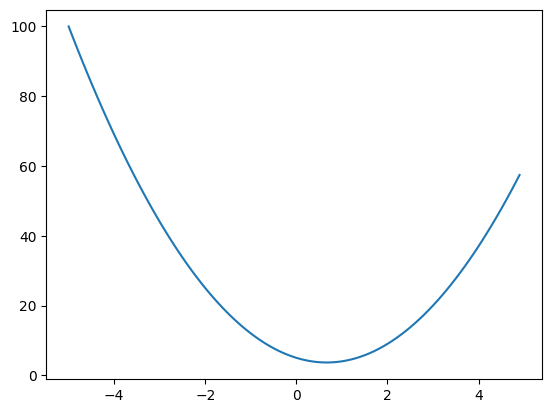

In [6]:
# call on array
xs = np.arange(-5, 5, 0.1)
ys = f(xs)
plt.plot(xs, ys)
list(zip(xs, ys))

Compute the approximation of the slope by taking a very small distance (h) and compute the difference between the function values when we nudge in this direction.

In [7]:
# compute the slop
h = 0.0000000000001
x = 3
(f(x + h) - f(x))/h

13.997691894473974

Make the same for a multi variable case - In that case we fix the inputs we are not interested in and derive for the other (partial derivative).

In [8]:
a = 10
b = 2
c = 3

def f2(a, b, c):
    return a**2 + b**2 + c**2

h = 0.000000001

# compute slope according to all there values
sa = (f2(a + h, b, c) - f2(a, b, c))/h
print(f"slope a: {sa}")

sb = (f2(a, b + h, c) - f2(a, b, c))/h
print(f"slope b: {sb}")

sc = (f2(a, b, c + h) - f2(a, b, c))/h
print(f"slope c: {sc}")

slope a: 20.00000165480742
slope b: 4.000000330961484
slope c: 5.999993391014868


/var/folders/8l/1_sx14l92sbg01mm4_s53_s40000gn/T/ipykernel_62511/4254409868.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


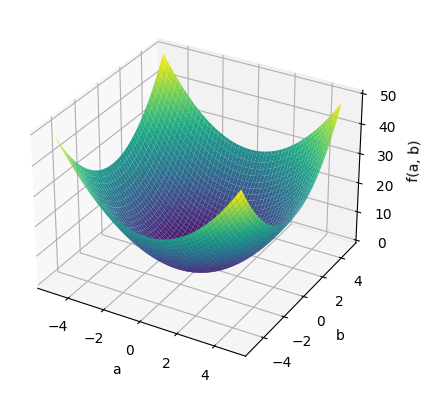

In [9]:
# print 3D plot of function
def f3(a, b):
    return a**2 + b**2

a = np.arange(-5, 5, 0.1)
b = np.arange(-5, 5, 0.1)
A, B = np.meshgrid(a, b)
Z = f3(A, B)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(A, B, Z, cmap='viridis')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('f(a, b)')
plt.show()

## Scafold of Micrograd

Now use wrapper functions to keep track of values

In [37]:
class Value:
    def __init__(self, data, name=None, _children=(), _op=None):
        self.data = data
        self.grad = 0
        self._name = name
        self._prev = set(_children)
        self._op = _op
    
    @property
    def id(self):
        return id(self)
    
    @property
    def name(self):
        if self._name is not None:
            return self._name
        if self._op is not None:
            return f"{self._op}({', '.join([c.name for c in self._prev])})"
        return f"Value({self.id})"
    
    @name.setter
    def name(self, value):
        self._name = value
    
    def __repr__(self):
        return f"Value({self.name}, data={self.data:.4f}, grad={self.grad:.4f})"
    
    def __add__(self, other):
        if not isinstance(other, Value):
            raise TypeError(f"unsupported operand type(s) for +: 'Value' and '{type(other)}'")
        return Value(self.data + other.data, _children=(self, other), _op='+')
    
    def __mul__(self, other):
        if not isinstance(other, Value):
            raise TypeError(f"unsupported operand type(s) for *: 'Value' and '{type(other)}'")
        return Value(self.data * other.data, _children=(self, other), _op='*')
    
    def __sub__(self, other):
        if not isinstance(other, Value):
            raise TypeError(f"unsupported operand type(s) for -: 'Value' and '{type(other)}'")
        return Value(self.data - other.data, _children=(self, other), _op='-')
    
    def tanh(self):
        return Value(math.tanh(self.data), _children=(self,), _op='tanh')

a = Value(3.0, name='a')
b = Value(-3.4, name='b')
c = a + b - a * b
c.name = 'c'
c

Value(c, data=9.8000, grad=0.0000)

Provide Printing code for the data:

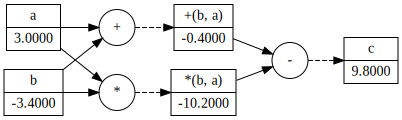

In [35]:
from graphviz import Digraph
from typing import Set, Tuple

def trace(value: Value) -> Tuple[Set[Value], Set[Tuple[Value, Value]]]:
    nodes, edges = set(), set()
    def _trace(value: Value):
        nodes.add(value)
        for prev in value._prev:
            edges.add((prev, value))
            _trace(prev)
    _trace(value)
    return nodes, edges

def plot(value: Value) -> Digraph:
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(value)
    for node in nodes:
        # add graph to dot
        dot.node(str(node.id), label=f"{node.name or ''} | {node.data:.4f}", shape='record')

        # add gradient to dot
        if node.grad != 0:
            dot.node(f"{node.id}_grad", label=f"{node.grad:.4f}", shape='circle')
            dot.edge(f"{node.id}_grad", str(node.id), style='dashed')
        
        # add operation to dot
        if node._op:
            dot.node(f"{node.id}_op", label=node._op, shape='circle')
            dot.edge(f"{node.id}_op", str(node.id), style='dashed')
    
    # add edges
    for src, dst in edges:
        dot.edge(str(src.id), f"{str(dst.id)}_op")
    
    return dot

plot(c)


Create a bit of a sample network:

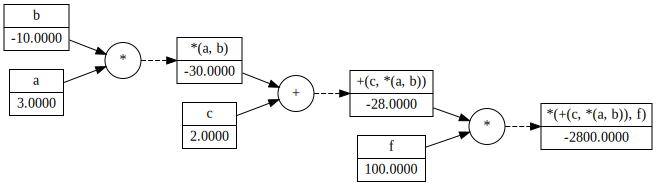

In [36]:
a = Value(3.0, name='a')
b = Value(-10, name='b')
c = Value(2, name='c')
e = a*b
d = c + e
f = Value(100, name='f')
L = d * f

plot(L)

## Neural Network

Next goal is to create a simple perceptron - then create a function for the forward pass and one for the backward pass.

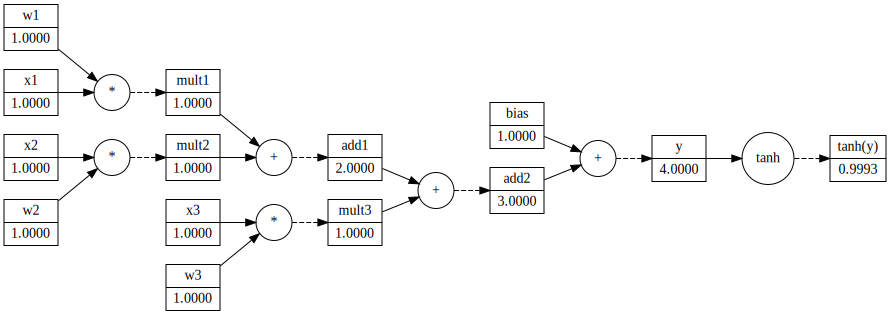

In [104]:
x1 = Value(1.0, name='x1')
x2 = Value(1.0, name='x2')
x3 = Value(1.0, name='x3')
w1 = Value(1.0, name='w1')
w2 = Value(1.0, name='w2')
w3 = Value(1.0, name='w3')

mult1 = x1 * w1; mult1.name = 'mult1'
mult2 = x2 * w2; mult2.name = 'mult2'
mult3 = x3 * w3; mult3.name = 'mult3'
add1 = mult1 + mult2; add1.name = 'add1'
add2 = add1 + mult3; add2.name = 'add2'

bias = Value(1.0, name='bias')
y = add2 + bias; y.name = 'y'

act = y.tanh()

plot(act)

In [105]:
# start with base gradiant of 1
# then iterate backwards based on the operation
def tanh_dev(x):
    # return 1/ (math.cosh(x) ** 2)
    return 1 - math.tanh(x) ** 2

def bstep():
    act.grad = 1
    y.grad = tanh_dev(y.data) * act.grad
    add2.grad = 1 * y.grad
    bias.grad = 1 * y.grad
    add1.grad = 1 * add2.grad
    mult3.grad = 1 * add2.grad
    x3.grad = w3.data * mult3.grad
    w3.grad = x3.data * mult3.grad
    mult1.grad = 1 * add1.grad
    mult2.grad = 1 * add1.grad
    x1.grad = w1.data * mult1.grad
    w1.grad = x1.data * mult1.grad
    x2.grad = w2.data * mult2.grad
    w2.grad = x2.data * mult2.grad

def optimize(lr: float = 0.01):
    w1.data += w1.grad * lr
    w2.data += w2.grad * lr
    w3.data += w3.grad * lr
    bias.data += bias.grad * lr

def fstep():
    mult1.data = x1.data * w1.data
    mult2.data = x2.data * w2.data
    mult3.data = x3.data * w3.data
    add1.data = mult1.data + mult2.data
    add2.data = add1.data + mult3.data
    y.data = add2.data + bias.data
    act.data = math.tanh(y.data)

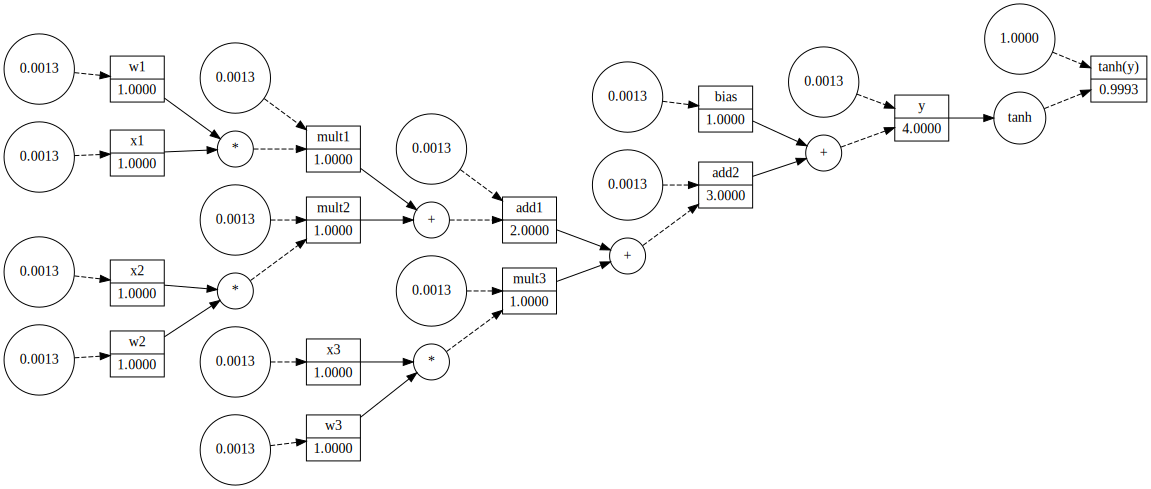

In [106]:
bstep()
plot(act)

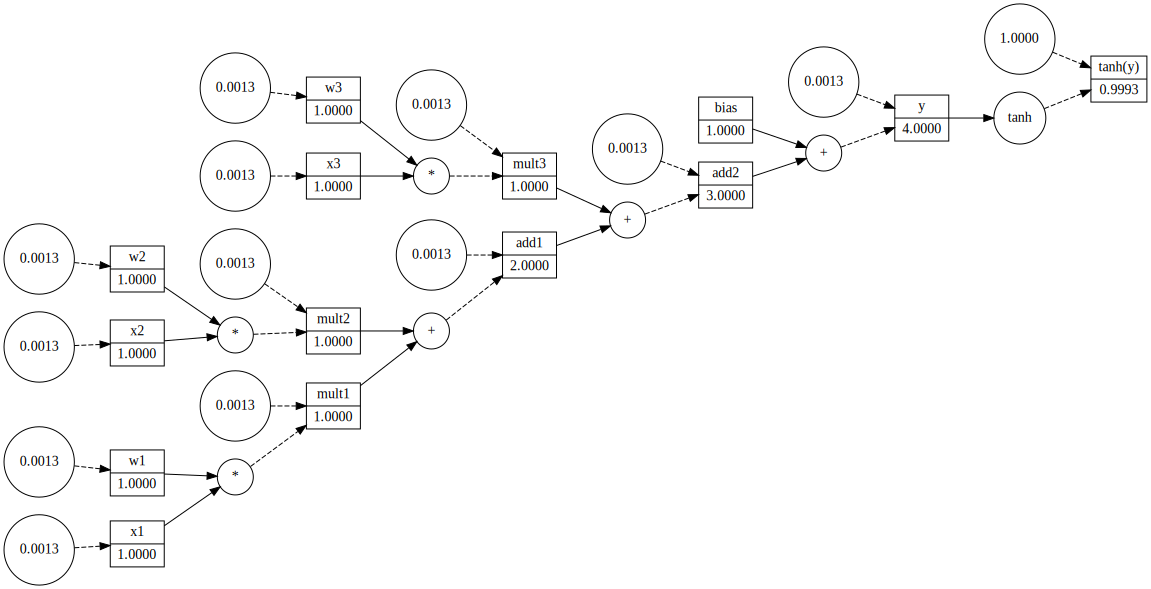

In [49]:
optimize()
plot(act)

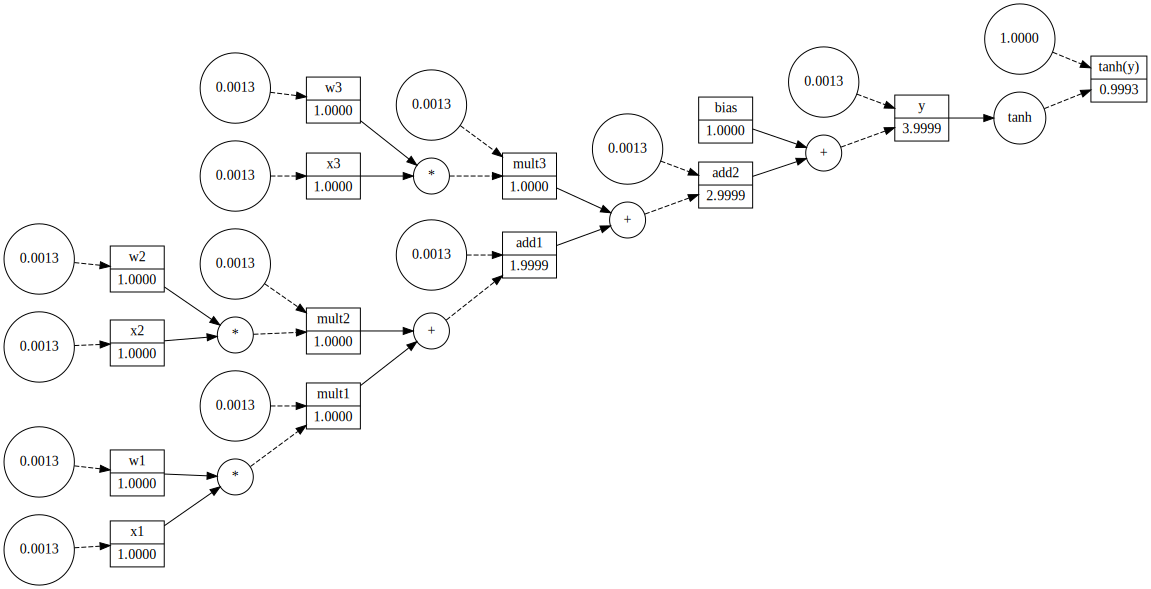

In [50]:
fstep()
plot(act)

loss: -0.998882
loss: -0.998902
loss: -0.998921
loss: -0.998939
loss: -0.998957
loss: -0.998974
loss: -0.998990
loss: -0.999006
loss: -0.999022
loss: -0.999037
loss: -0.999052
loss: -0.999066
loss: -0.999080
loss: -0.999093
loss: -0.999106
loss: -0.999118
loss: -0.999131
loss: -0.999143
loss: -0.999154
loss: -0.999166
loss: -0.999176
loss: -0.999187
loss: -0.999198
loss: -0.999208
loss: -0.999218
loss: -0.999227
loss: -0.999237
loss: -0.999246
loss: -0.999255
loss: -0.999264
loss: -0.999272
loss: -0.999281
loss: -0.999289
loss: -0.999297
loss: -0.999305
loss: -0.999312
loss: -0.999320
loss: -0.999327
loss: -0.999334
loss: -0.999341
loss: -0.999348
loss: -0.999355
loss: -0.999361
loss: -0.999368
loss: -0.999374
loss: -0.999380
loss: -0.999387
loss: -0.999392
loss: -0.999398
loss: -0.999404
loss: -0.999410
loss: -0.999415
loss: -0.999421
loss: -0.999426
loss: -0.999431
loss: -0.999436
loss: -0.999441
loss: -0.999446
loss: -0.999451
loss: -0.999456
loss: -0.999461
loss: -0.999465
loss: -0

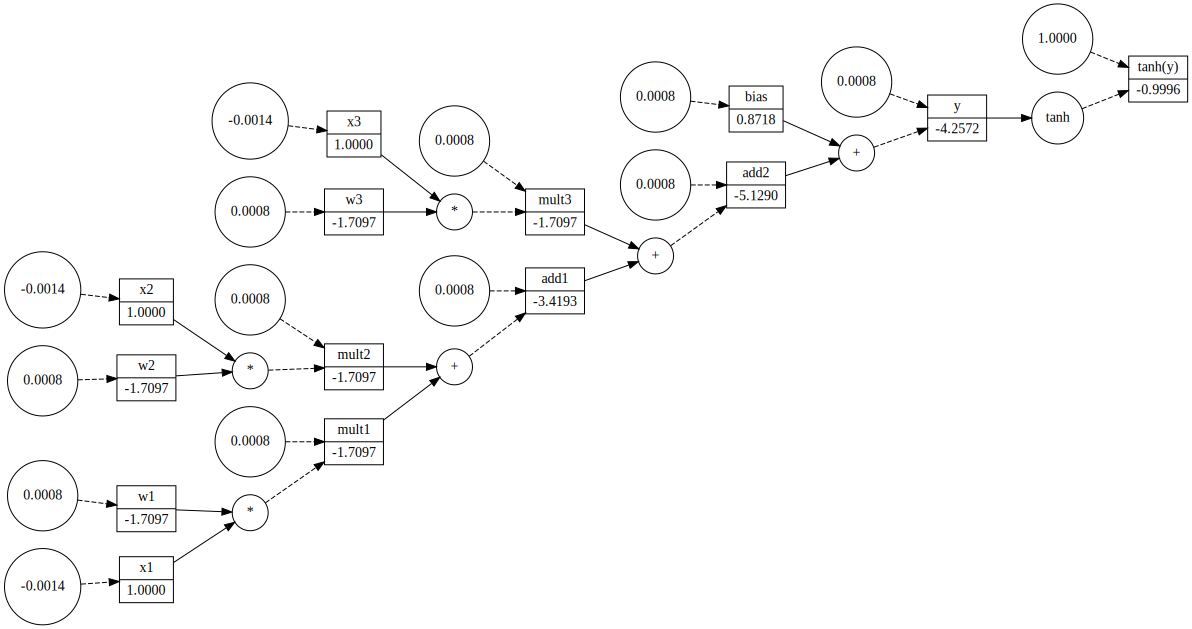

In [101]:
# run a few iterations
for i in range(10000):
    bstep()
    optimize(-0.01)
    fstep()
    if i % 100 == 0:
        print(f"loss: {act.data:.6f}")
plot(act)

In [ ]:
# TODO: properly implement backward pass